<a href="https://colab.research.google.com/github/triciat/Tensorflow-in-Practice/blob/main/Course_3_NLP/Course_3_Week_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%202%20-%20Lesson%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LESSON 1

In [28]:
import tensorflow as tf
print(tf.__version__)

# !pip install -q tensorflow-datasets

### If still using tensorflow 1.0
# tf.enable_eager_execution()

2.4.1


In [29]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


In [30]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [67]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# training
tokenizer = Tokenizer ( num_words = vocab_size, oov_token=oov_tok)
Tokenizer()
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# testing
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


In [31]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))
print(training_sentences[3])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you <OOV> into a big arm chair and <OOV> for a couple of hours wonderful performances from cher and nicolas cage as always gently row the plot along there are no <OOV> to cross no dangerous waters just a warm and witty <OOV> through new york life at its best a family film in every sense and one that deserves the praise it received
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.


### Flatten (Slower but more accurate)


In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),   #### The KEY to sentiment analysis
    tf.keras.layers.Flatten(),        #faster alternative: tf.keras.layers.GlobalAveragePooling1D()
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 11526     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [33]:
num_epochs = 10
model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 5s 6ms/step - loss: 0.6019 - accuracy: 0.6399 - val_loss: 0.3424 - val_accuracy: 0.8485
Epoch 2/10
782/782 [==============================] - 5s 6ms/step - loss: 0.2459 - accuracy: 0.9052 - val_loss: 0.3564 - val_accuracy: 0.8451
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: 0.1100 - accuracy: 0.9720 - val_loss: 0.4421 - val_accuracy: 0.8304
Epoch 4/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0276 - accuracy: 0.9967 - val_loss: 0.5181 - val_accuracy: 0.8274
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0065 - accuracy: 0.9997 - val_loss: 0.5998 - val_accuracy: 0.8274
Epoch 6/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.6445 - val_accuracy: 0.8308
Epoch 7/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.6870 - val_accuracy: 0.8308
Epoch 

### Global Average Pooling 1D (faster)

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),   #### The KEY to sentiment analysis
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 102       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________


In [35]:
num_epochs = 10
model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 6s 7ms/step - loss: 0.6439 - accuracy: 0.6613 - val_loss: 0.3909 - val_accuracy: 0.8434
Epoch 2/10
782/782 [==============================] - 5s 6ms/step - loss: 0.3536 - accuracy: 0.8577 - val_loss: 0.3359 - val_accuracy: 0.8558
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: 0.2707 - accuracy: 0.8909 - val_loss: 0.3285 - val_accuracy: 0.8585
Epoch 4/10
782/782 [==============================] - 5s 6ms/step - loss: 0.2368 - accuracy: 0.9080 - val_loss: 0.3390 - val_accuracy: 0.8543
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: 0.2087 - accuracy: 0.9233 - val_loss: 0.3584 - val_accuracy: 0.8492
Epoch 6/10
782/782 [==============================] - 5s 6ms/step - loss: 0.1874 - accuracy: 0.9334 - val_loss: 0.3809 - val_accuracy: 0.8453
Epoch 7/10
782/782 [==============================] - 5s 6ms/step - loss: 0.1636 - accuracy: 0.9457 - val_loss: 0.4103 - val_accuracy: 0.8389
Epoch 

In [12]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


##### Decode codes back to words for visualization

In [36]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [37]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Visualization

###### Upload vecs.tsv and meta.tsv files to the website

http://projector.tensorflow.org/

In [15]:
sentence = "I really think this is amazing. honest."
sequence = tokenizer.texts_to_sequences([sentence])
print(sequence)

[[11, 64, 102, 12, 7, 478, 1200]]


# LESSON 2

In [38]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [39]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [40]:
vocab_size = 10000    #1000
embedding_dim = 16    #32
max_length = 100      #16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [41]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json


--2021-02-18 05:02:43--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.7.144, 172.217.164.176, 172.217.9.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.7.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.02s   

2021-02-18 05:02:43 (243 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [42]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [43]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [44]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [45]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [47]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [48]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 24)                408       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [49]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 3s - loss: 0.6578 - accuracy: 0.5945 - val_loss: 0.5599 - val_accuracy: 0.7488
Epoch 2/30
625/625 - 2s - loss: 0.4230 - accuracy: 0.8364 - val_loss: 0.3841 - val_accuracy: 0.8438
Epoch 3/30
625/625 - 2s - loss: 0.3090 - accuracy: 0.8788 - val_loss: 0.3520 - val_accuracy: 0.8545
Epoch 4/30
625/625 - 2s - loss: 0.2585 - accuracy: 0.8995 - val_loss: 0.3465 - val_accuracy: 0.8566
Epoch 5/30
625/625 - 2s - loss: 0.2229 - accuracy: 0.9161 - val_loss: 0.3524 - val_accuracy: 0.8462
Epoch 6/30
625/625 - 2s - loss: 0.1987 - accuracy: 0.9255 - val_loss: 0.3564 - val_accuracy: 0.8517
Epoch 7/30
625/625 - 2s - loss: 0.1760 - accuracy: 0.9345 - val_loss: 0.3729 - val_accuracy: 0.8474
Epoch 8/30
625/625 - 2s - loss: 0.1586 - accuracy: 0.9414 - val_loss: 0.3746 - val_accuracy: 0.8523
Epoch 9/30
625/625 - 2s - loss: 0.1423 - accuracy: 0.9498 - val_loss: 0.3884 - val_accuracy: 0.8518
Epoch 10/30
625/625 - 2s - loss: 0.1302 - accuracy: 0.9541 - val_loss: 0.4052 - val_accuracy: 0.8530

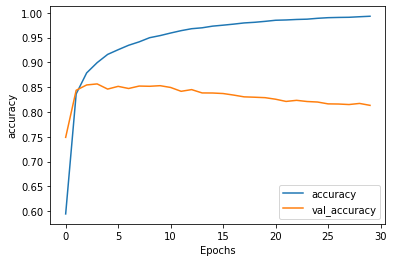

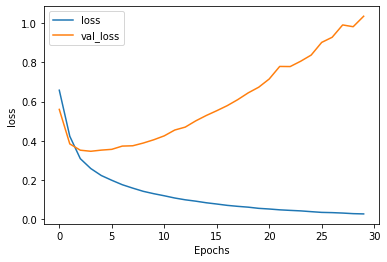

In [51]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Loss: a confidence in the prediction
## In text data, it's common to see that while the number of accruate predictions increased over time the conficence per prediction effectively decreased 
## What can be tried in hyperparameter tuning:a decrease in vocabulary size, and taking shorter sentences, reducing the likelihood of padding

In [52]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [53]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 16)


In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [ ]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

# LESSON 3

In [54]:
# NOTE: PLEASE MAKE SURE YOU ARE RUNNING THIS IN A PYTHON3 ENVIRONMENT

import tensorflow as tf
print(tf.__version__)


2.4.1


In [ ]:
# Uncomment and run this if oyu don't have Tensorflow 2.0x
# !pip install tensorflow == 2.0.0-alpha0

In [55]:
# Double check TF 2.0x is installed. If you ran the above block, there was a 
# 'reset all runtimes' button at the bottom that you needed to press
import tensorflow as tf
print(tf.__version__)

2.4.1


In [56]:
# If the import fails, run this
# !pip install -q tensorflow-datasets

import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteAR9ITK/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteAR9ITK/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteAR9ITK/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [57]:
train_data, test_data = imdb['train'], imdb['test']

In [58]:
tokenizer = info.features['text'].encoder

In [59]:
print(tokenizer.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

In [60]:
sample_string = 'TensorFlow, from basics to mastery'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))


Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery


In [61]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


In [62]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_data.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))

In [63]:
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),   # 不能用flatten不然tensorflow會crash, 因為不好flatten
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 390       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


In [64]:
num_epochs = 10

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 12s 29ms/step - loss: 0.6902 - accuracy: 0.5242 - val_loss: 0.6374 - val_accuracy: 0.7649
Epoch 2/10
391/391 [==============================] - 11s 28ms/step - loss: 0.5744 - accuracy: 0.7680 - val_loss: 0.4438 - val_accuracy: 0.8290
Epoch 3/10
391/391 [==============================] - 12s 28ms/step - loss: 0.3917 - accuracy: 0.8642 - val_loss: 0.3573 - val_accuracy: 0.8665
Epoch 4/10
391/391 [==============================] - 11s 28ms/step - loss: 0.3034 - accuracy: 0.8949 - val_loss: 0.3267 - val_accuracy: 0.8745
Epoch 5/10
391/391 [==============================] - 11s 28ms/step - loss: 0.2588 - accuracy: 0.9097 - val_loss: 0.3330 - val_accuracy: 0.8603
Epoch 6/10
391/391 [==============================] - 11s 28ms/step - loss: 0.2347 - accuracy: 0.9172 - val_loss: 0.3049 - val_accuracy: 0.8817
Epoch 7/10
391/391 [==============================] - 11s 28ms/step - loss: 0.2203 - accuracy: 0.9229 - val_loss: 0.3073 - val_accuracy:

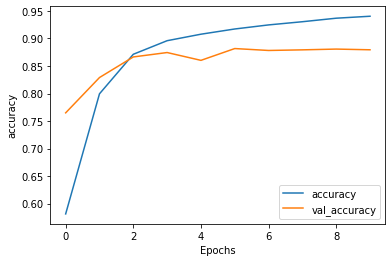

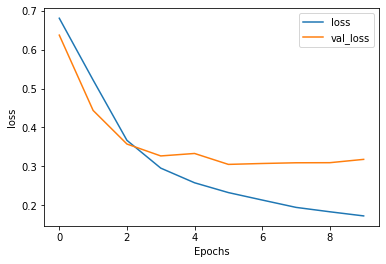

In [65]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [66]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, tokenizer.vocab_size):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()


try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

(8185, 64)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>